# Predicting Car Prices
In this project, I am going to predict a car's market price using its attributes. [The dataset](https://archive.ics.uci.edu/ml/datasets/automobile) I will be working with contains information on various cars. For each car, there is information about the technical aspects of the vehicle such as the motor's displacement, the weight of the car, the miles per gallon, how fast the car accelerates, and more.

The [k-nearest neighbors algorithm](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) will be used in this project.
Let's read and explore the dataset first.

In [1]:
import pandas as pd
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv('imports-85.data', names=cols)

cars.head(5)

symboling normalized-losses         make fuel-type aspiration num-of-doors  \
0          3                 ?  alfa-romero       gas        std          two   
1          3                 ?  alfa-romero       gas        std          two   
2          1                 ?  alfa-romero       gas        std          two   
3          2               164         audi       gas        std         four   
4          2               164         audi       gas        std         four   

    body-style drive-wheels engine-location  wheel-base  ...  engine-size  \
0  convertible          rwd           front        88.6  ...          130   
1  convertible          rwd           front        88.6  ...          130   
2    hatchback          rwd           front        94.5  ...          152   
3        sedan          fwd           front        99.8  ...          109   
4        sedan          4wd           front        99.4  ...          136   

   fuel-system  bore  stroke compression-rate horsepower  peak-rpm city-mpg  \
0         mpfi  3.47    2.68              9.0        111      5000       21   
1         mpfi  3.47    2.68              9.0        111      5000       21   
2         mpfi  2.68    3.47              9.0        154      5000       19   
3         mpfi  3.19    3.40             10.0        102      5500       24   
4         mpfi  3.19    3.40              8.0        115      5500       18   

  highway-mpg  price  
0          27  13495  
1          27  16500  
2          26  16500  
3          30  13950  
4          22  17450  

[5 rows x 26 columns]

In [2]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [3]:
cars.shape

(205, 26)

To use the k-nearest neighbors algorithm, all columns should be numeric so let's determine the continuous columns and perform some data cleaning to make sure they are all numeric.  

In [4]:
numeric_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars_numeric = cars[numeric_cols]

## Data Cleaning

the **normalized-losses** column contains missing values represented using "?". I need to replace these values and look for the presence of missing values in other numeric columns. Let's also rescale the values in the numeric columns so they all range from 0 to 1.

In [5]:
import numpy as np
cars_numeric = cars_numeric.replace("?", np.nan)
cars_numeric['normalized-losses'] = cars_numeric['normalized-losses'].astype('float')

Let's turn all the columns into float and see which columns have null values.

In [6]:
cars_numeric = cars_numeric.astype('float')
cars_numeric.isnull().sum()

normalized-losses    41
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Since **price** is the target value, I am going to remove the entire rows contains the null price.

In [7]:
cars_numeric = cars_numeric.dropna(subset=['price'])
cars_numeric.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-size           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

I am going to replace the mean value of each column in the rest of the null values.

In [8]:
cars_numeric = cars_numeric.fillna(cars_numeric.mean())
cars_numeric.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-size          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

The above result shows that there are no more null values in the dataset.

## Normalize columns

To use the k-nearest neighbors model, I need to normalize all values range from 0 to 1 except the price column.

In [9]:
price_col = cars_numeric['price']
cars_numeric = (cars_numeric - cars_numeric.min())/(cars_numeric.max() - cars_numeric.min())
cars_numeric['price'] = price_col

Before modeling the dataset, it can be helpful to look at the distribution of price.

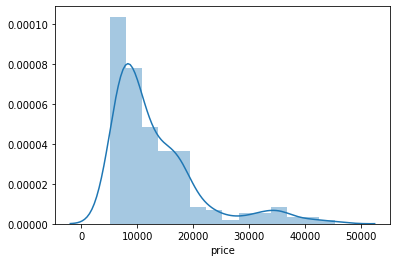

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(cars_numeric['price'])
plt.show()

The price distribution is skewed so k-nearest neighbors may not work well for the cars with high prices (more than 20000).

I want to use correlation function to see which columns are correlated with price.

In [11]:
correlations = cars_numeric.corr()
correlations[(correlations["price"]>=0.25) | (correlations["price"]<= -0.25)]['price'].sort_values(ascending = False)

price          1.000000
engine-size    0.872335
curb-weight    0.834415
horsepower     0.809681
width          0.751265
length         0.690628
wheel-base     0.584642
bore           0.543154
city-mpg      -0.686571
highway-mpg   -0.704692
Name: price, dtype: float64

There are lots of columns that have correlation with the price column. Among them **engine-size**, **curb-weight** and **horsepower** have higher correlation values.

## Univariate k-nearest neighbors

Let's start with the univariate k-nearest neighbors model and write a function to get in one column as a feature, the target column, and the dataset and return the root mean squared error (rmse) with predictions and actual prices.

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
def knn_train_test(train_col, target_col, df):
    
    #Shuffle dataframe
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Define train and test dataframes
    middle = int(rand_df.shape[0]/2)
    train_df = rand_df.iloc[0:middle]
    test_df = rand_df.iloc[middle:]
   
    #Run KNeighborsRegressor
    knn = KNeighborsRegressor()
    knn.fit(train_df[[train_col]], train_df[target_col])
    predictions = knn.predict(test_df[[train_col]])
    rmse = mean_squared_error(test_df[target_col], predictions)**(1/2)
    
    return rmse

In [13]:
#Remove the target col to have the list of features only
numeric_cols.remove('price')

In [14]:
#Apply the knn_train_test to all features
rmses = {}
for col in numeric_cols:
    rmses[col] = knn_train_test(col, 'price', cars_numeric)
rmses


{'normalized-losses': 7330.197653434445,
 'wheel-base': 5461.553997873057,
 'length': 5427.2009608367125,
 'width': 4704.482589704386,
 'height': 8144.441042663747,
 'curb-weight': 4401.118254793124,
 'engine-size': 3238.4628296477176,
 'bore': 6780.627784685976,
 'stroke': 8006.529544647101,
 'compression-rate': 6610.812153159129,
 'horsepower': 4037.0377131537603,
 'peak-rpm': 7697.4596964334805,
 'city-mpg': 4766.422505090134,
 'highway-mpg': 4630.026798588056}

In [15]:
#Find out which column has the minimum RMSE for the default k value
min_rmse_col = min(rmses, key=rmses.get)
print("The column with minimum RMSE using the defult k: {}".format(min_rmse_col))

The column with minimum RMSE using the defult k: engine-size


The minimum RMSE of the univariate model is **3238** for the default k value. At this stage, I am going to modify the knn_train_test function to accept a parameter for **k** value and test if with different k values.

In [16]:
def knn_train_test_k(train_col, target_col, df, k):
    
    #Shuffle dataframe
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Define train and test dataframes
    middle = int(rand_df.shape[0]/2)
    train_df = rand_df.iloc[0:middle]
    test_df = rand_df.iloc[middle:]
   
    #Run KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train_df[[train_col]], train_df[target_col])
    predictions = knn.predict(test_df[[train_col]])
    rmse = mean_squared_error(test_df[target_col], predictions)**(1/2)
    
    return rmse, list(predictions), list(test_df[target_col])

rmses_k = {}
predictions = {}
prices = {}
for col in numeric_cols:
    k_values = {}
    prediction = {}
    price = {}
    for k in [1, 3, 5, 7, 9]:
        k_values[k], prediction[k], price[k] = knn_train_test_k(col, 'price', cars_numeric, k)
    rmses_k[col] = k_values
    predictions[col] = prediction
    prices[col] = price
rmses_k

{'normalized-losses': {1: 7846.750605148984,
  3: 7500.5698123109905,
  5: 7330.197653434445,
  7: 7756.421586234123,
  9: 7688.096096891432},
 'wheel-base': {1: 4493.734068810494,
  3: 5120.161506064513,
  5: 5461.553997873057,
  7: 5448.1070513823315,
  9: 5738.405685192312},
 'length': {1: 4628.45550121557,
  3: 5129.8358210721635,
  5: 5427.2009608367125,
  7: 5313.427720847974,
  9: 5383.054514833446},
 'width': {1: 4559.257297950061,
  3: 4606.413692169901,
  5: 4704.482589704386,
  7: 4571.485046194653,
  9: 4652.914172067787},
 'height': {1: 8904.04645636071,
  3: 8277.609643045525,
  5: 8144.441042663747,
  7: 7679.598124393773,
  9: 7811.03606291223},
 'curb-weight': {1: 5264.290230758878,
  3: 5022.318011757233,
  5: 4401.118254793124,
  7: 4330.608104418053,
  9: 4632.044474454401},
 'engine-size': {1: 3258.4861059962027,
  3: 2840.562805643501,
  5: 3238.4628296477176,
  7: 3563.086774256415,
  9: 3831.8244149840766},
 'bore': {1: 8602.58848450066,
  3: 6984.239489480916,


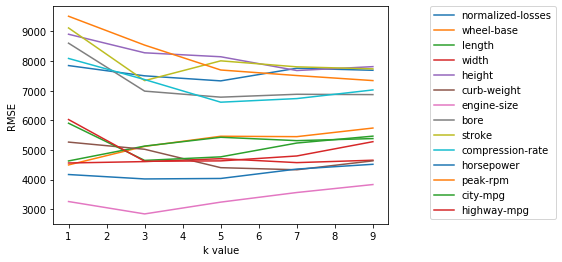

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

for k,v in rmses_k.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y, label = k)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.legend(bbox_to_anchor=(1.5,1), borderaxespad=0) 


The **engine-size** column has the lowest RMSE for all k values and the minimum RMSE for this column is at k = 3.
The k value with the minimum RMSE differs for each column.

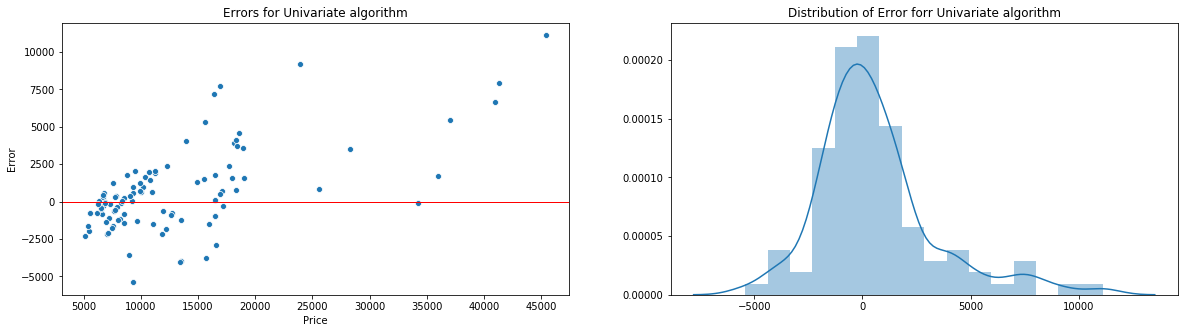

In [18]:
def draw_error_plots(x, y, algorithm):
    fig, axes = plt.subplots(ncols=2, figsize=(20,5))

    #Scatter plot
    sns.scatterplot(x = x, 
                    y = y, 
                    ax = axes[0])
    axes[0].set_xlabel('Price')
    axes[0].set_ylabel('Error')
    axes[0].set_title('Errors for {} algorithm'.format(algorithm))
    axes[0].axhline(linewidth=1, color='r')


    #Distribution plot
    sns.distplot(y, ax = axes[1])
    axes[1].set_title('Distribution of Error forr {} algorithm'.format(algorithm))
    
draw_error_plots(x = prices['engine-size'][3], 
                 y= list(np.array(prices['engine-size'][3]) - np.array(predictions['engine-size'][3])), algorithm = 'Univariate')

The above scatter plot shows that the univariate k-nearest neighbors algorithm predicts better for lower prices. The distribution diagram of errors (the difference between prices and predictions) is skewed to the right which means there are some cars with prices significantly higher than predictions.

## Multivariate Model
In multivariate model more than one feature is used for prediction so It can be useful to modify the knn_train_test function to accept a list of column names instead of just one column name.

In [19]:
def knn_train_test(train_cols, target_col, df):
    
    #Shuffle dataframe
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Define train and test dataframes
    middle = int(rand_df.shape[0]/2)
    train_df = rand_df.iloc[0:middle]
    test_df = rand_df.iloc[middle:]
   
    #Run KNeighborsRegressor
    knn = KNeighborsRegressor()
    knn.fit(train_df[train_cols], train_df[target_col])
    predictions = knn.predict(test_df[train_cols])
    rmse = mean_squared_error(test_df[target_col], predictions)**(1/2)
    
    return rmse

Let's calculate the average of RMSE for each column, sort columns according to the average of RMSE, and test according to the best result.

In [20]:
import statistics
mean_rmse = {}
for k,v in rmses_k.items():
    mean_rmse[k] =statistics.mean(list(v.values()))
sorted_mean_rmse = sorted(mean_rmse.items(), key=lambda x: x[1])
sorted_mean_rmse

[('engine-size', 3346.484586105583),
 ('horsepower', 4219.377860395268),
 ('width', 4618.910559617358),
 ('curb-weight', 4730.075815236338),
 ('highway-mpg', 5069.469256447656),
 ('length', 5176.394903761173),
 ('city-mpg', 5202.409002973381),
 ('wheel-base', 5252.3924618645415),
 ('compression-rate', 7166.073598733105),
 ('bore', 7222.472445325499),
 ('normalized-losses', 7624.407150803995),
 ('stroke', 8000.240466568113),
 ('peak-rpm', 8119.365233100782),
 ('height', 8163.346265875197)]

In [21]:
rmses = {}
 #for each model
for m in range(2, 6):
    #create the coresponding columns
    cols = []
    for c in range (0, m):
        cols.append(sorted_mean_rmse[c][0])
    #For different k value apply the function
    m_title = '{} best features'.format(m)
    rmses[m_title] = knn_train_test(cols, 'price', cars_numeric)
print("RMSE for different models:")
rmses

RMSE for different models:


{'2 best features': 2949.8817277180374,
 '3 best features': 3580.7376651928435,
 '4 best features': 3487.340917327035,
 '5 best features': 3410.2170133901805}

The best result is with two best features **engine-size** and **horsepower**.

### Hyperparameter Tuning

I am going to pass the k parameter to the knn_train_test function as well and then try to figure out which k value is optimal for the models of the last section.

In [22]:
def knn_train_test(train_cols, target_col, df, k):
    
    #Shuffle dataframe
    np.random.seed(1)
    
    shuffled_index = np.random.permutation(df.index)
    rand_df = df.reindex(shuffled_index)
    
    #Define train and test dataframes
    middle = int(rand_df.shape[0]/2)
    train_df = rand_df.iloc[0:middle]
    test_df = rand_df.iloc[middle:]
   
    #Run KNeighborsRegressor
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(train_df[train_cols], train_df[target_col])
    predictions = knn.predict(test_df[train_cols])
    rmse = mean_squared_error(test_df[target_col], predictions)**(1/2)
    
    return rmse, list(predictions), list(test_df[target_col])

In [23]:
#Apply knn_train_test function to all models with k values ranges from 1 to 25 
rmses_model = {}
predictions_model = {}
prices_model = {}
#for each model
for m in range(2, 6):
    #create the coresponding columns
    cols = []
    for c in range (0, m):
        cols.append(sorted_mean_rmse[c][0])
    #For different k value apply the function
    rmses = {}
    for k in range(1, 26):    
        rmses[k], predictions[k], prices[k] = knn_train_test(cols, 'price', cars_numeric, k)
    rmses_model['{} best features'.format(m)] = rmses
    predictions_model['{} best features'.format(m)] = predictions
    prices_model['{} best features'.format(m)] = prices
rmses_model

{'2 best features': {1: 2783.6204237227344,
  2: 2657.7963807419765,
  3: 2792.586573031673,
  4: 2891.5329686923255,
  5: 2949.8817277180374,
  6: 3096.402601694776,
  7: 3164.681969020496,
  8: 3413.228359192009,
  9: 3748.6716603306486,
  10: 4080.7125057341937,
  11: 4215.6372280600335,
  12: 4275.421524277872,
  13: 4373.901683035496,
  14: 4424.285137239815,
  15: 4539.505493095937,
  16: 4667.307671446768,
  17: 4729.605305844226,
  18: 4790.556632159094,
  19: 4824.3866193292615,
  20: 4840.850914693829,
  21: 4837.429062000271,
  22: 4831.16988267597,
  23: 4861.679492959275,
  24: 4903.346008862579,
  25: 4955.892429427362},
 '3 best features': {1: 3399.8148100410203,
  2: 3497.191103423058,
  3: 3333.6966577570593,
  4: 3355.8842294742026,
  5: 3580.7376651928435,
  6: 3732.943016673517,
  7: 3639.9439408462786,
  8: 3747.4209132113137,
  9: 3986.593913133887,
  10: 4005.354888715163,
  11: 4121.687230061635,
  12: 4255.700651624227,
  13: 4328.476829895253,
  14: 4332.21649

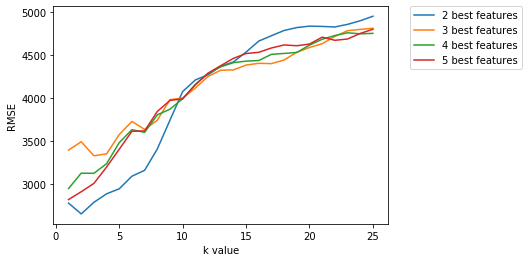

In [24]:
for k,v in rmses_model.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y, label = k)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
    plt.legend(bbox_to_anchor=(1.4,1), borderaxespad=0) 

Let's see which k value is optimal for each model.

In [25]:
best_k = {}
for key,value in rmses_model.items():
    k = min(value, key=value.get)
    best_k['best k for {} best featues:'.format(key)] = k
best_k

{'best k for 2 best features best featues:': 2,
 'best k for 3 best features best featues:': 3,
 'best k for 4 best features best featues:': 1,
 'best k for 5 best features best featues:': 1}

The **minimum RMSE** has been achived by using **2 features** and **k = 2** is **2658**.

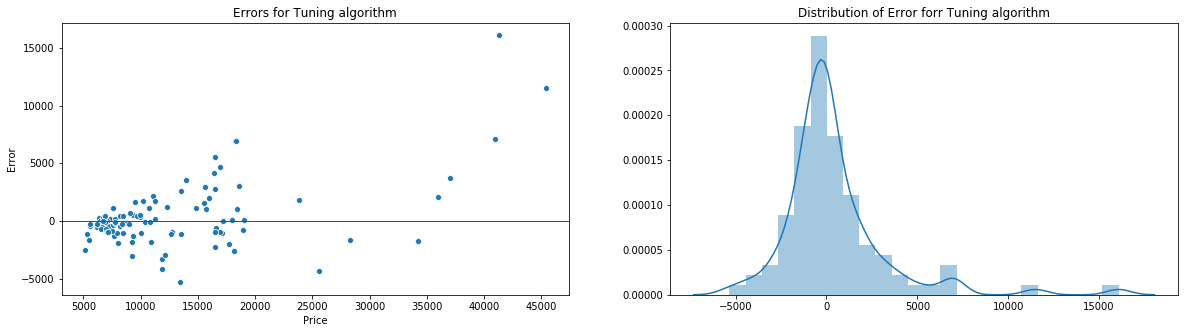

In [26]:
draw_error_plots(x = prices_model['2 best features'][2] 
                 , y= list(np.array(prices_model['2 best features'][2]) - np.array(predictions_model['2 best features'][2]))
                 , algorithm = 'Tuning')

Looking at the distribution of errors it is still skewed to the right.

## K-fold cross validation

I am going to modify **knn_train_test** again to use [k-fold cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) instead of test/train validation. This function returns the standard deviation (STD) of RMSE values as well. The goal is to get the lowest possible RMSE and STD which is actually a trade-off. 

We figure out that the minimum RMSE of the previous section is when k is 2 so to test the k-fold cross validation function I am going to set k=2.

In [27]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
def knn_train_test(train_cols, target_col, df, k, k_fold):
    kf = KFold(k_fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor(n_neighbors = k)
    mses = cross_val_score(model, df[train_cols], df[target_col], scoring="neg_mean_squared_error", cv=kf)
    
    predictions = cross_val_predict(model, df[train_cols], df[target_col], cv = kf)
    
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    return avg_rmse, std_rmse, list(predictions)

rmse_fold = {}
std_fold = {}
predictions_fold = {}
num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23]

for m in range(2, 6):    
    cols = []
    for c in range (0, m):
        cols.append(sorted_mean_rmse[c][0]) 
    rmses = {}
    stds = {}
    predictions = {}
    for fold in num_folds:  
        rmses[fold], stds[fold], predictions[fold]= knn_train_test(cols, 'price', cars_numeric, 2, fold)        
    rmse_fold['{} best features'.format(m)] = rmses
    std_fold['{} best features'.format(m)] = stds
    predictions_fold['{} best features'.format(m)] = predictions
rmse_fold

{'2 best features': {3: 2977.491628824817,
  5: 2782.7433273032293,
  7: 2818.6005454006267,
  9: 2733.2332757877725,
  10: 2601.2320598273477,
  11: 2748.4452013986347,
  13: 2742.245747407014,
  15: 2672.4052325517664,
  17: 2656.714902131989,
  19: 2682.115091326454,
  21: 2468.9059931505594,
  23: 2604.332961115949},
 '3 best features': {3: 2778.2960497182344,
  5: 2759.980734082431,
  7: 2763.9151730833332,
  9: 2695.236696221519,
  10: 2703.564030002367,
  11: 2694.4000849927875,
  13: 2709.4821503683684,
  15: 2647.515020103927,
  17: 2571.2946619915524,
  19: 2568.815456470527,
  21: 2516.821783824209,
  23: 2519.7479971994885},
 '4 best features': {3: 2777.825768864437,
  5: 2715.635212564693,
  7: 2731.492992675999,
  9: 2617.851947029708,
  10: 2587.874651022591,
  11: 2592.9202750529726,
  13: 2645.2073922248087,
  15: 2535.624058205171,
  17: 2496.1845160347116,
  19: 2467.689279668956,
  21: 2424.9990686379974,
  23: 2382.3256554356776},
 '5 best features': {3: 2806.98712

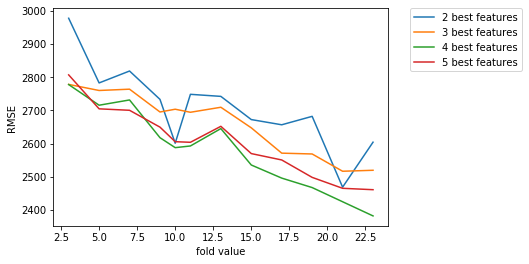

In [28]:
for k,v in rmse_fold.items():    
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y, label = k)
    plt.xlabel('fold value')
    plt.ylabel('RMSE')
    plt.legend(bbox_to_anchor=(1.4,1), borderaxespad=0) 

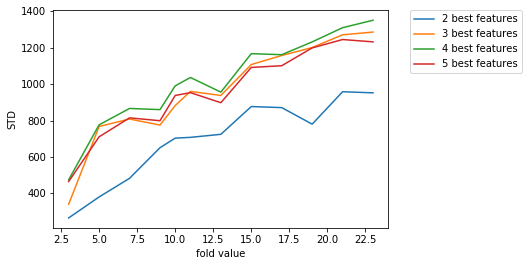

In [29]:
for k,v in std_fold.items():    
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y, label = k)
    plt.xlabel('fold value')
    plt.ylabel('STD')
    plt.legend(bbox_to_anchor=(1.4,1), borderaxespad=0) 

The above plots show that when k is 2, 2 best features model has the lowest STD but RMSE is higher than the other models except for fold = 10 and 21 (10 looks even better than 21). So it seems when k is 2 one of the best predictions can be achieved using 2 features model with 10 folds. The RMSE is **2601** which is a better result than the RMSE of the previous section.

Let's look at the errors more precisely.

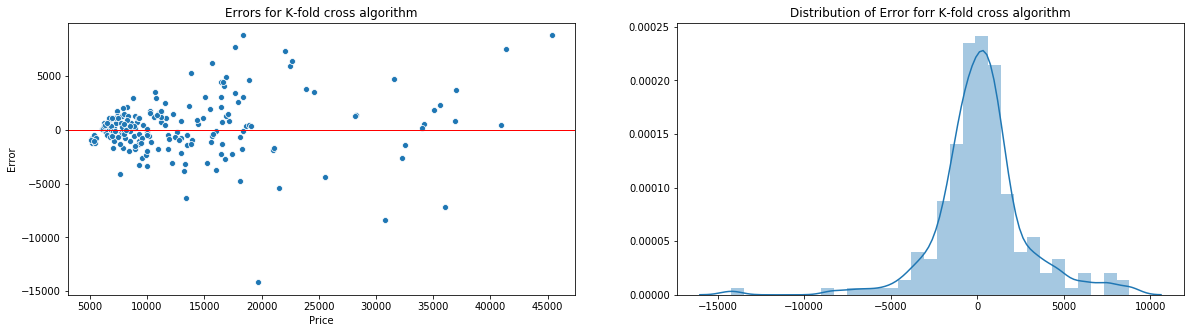

In [30]:
draw_error_plots(x = cars_numeric['price'] 
                 , y= list(np.array(cars_numeric['price']) - np.array(predictions_fold['2 best features'][10]))
                 , algorithm = 'K-fold cross')

Except for one outlier, the other errors are in the smaller range of values than the errors of the other models and the distribution of errors is close to normal that represents a good result.

## Summary and next steps

In this project, I tried to use some k-nearest neighbors algorithms to get the best predictions for car prices. Univariate and Multivariate models and K-fold cross validation has been used with the following results:


Model                |RMSE     |K |Fold|Features               
---------------------|---------|--|----|-----------------------
Univariate           |3238     |5 |2   | engine_size           
Multivariate         |2658     |2 |2   |engine_size, horsepower
K-fold cross         |**2601** |2 |10  |engine_size, horsepower


The best result has been achieved by the k-fold cross with keeping 2 as the number of neighbors, using 10 folds and 2 best features model. The distribution of errors in this model was close to normal.

**Suggested next Steps**:
- Test k-fold cross validation with different numbers of neighbors.
- Collect more data about high price cars.